## Cluster headache distribution and suffering quantification

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, truncnorm
from scipy.optimize import curve_fit, minimize

## Lognormal fit of CH frequency distribution

Using the data from [Cluster Headache Frequency Follows a Long-Tail Distribution](https://forum.effectivealtruism.org/posts/XLrzi6TrCqhTMtf8d/cluster-headache-frequency-follows-a-long-tail-distribution)

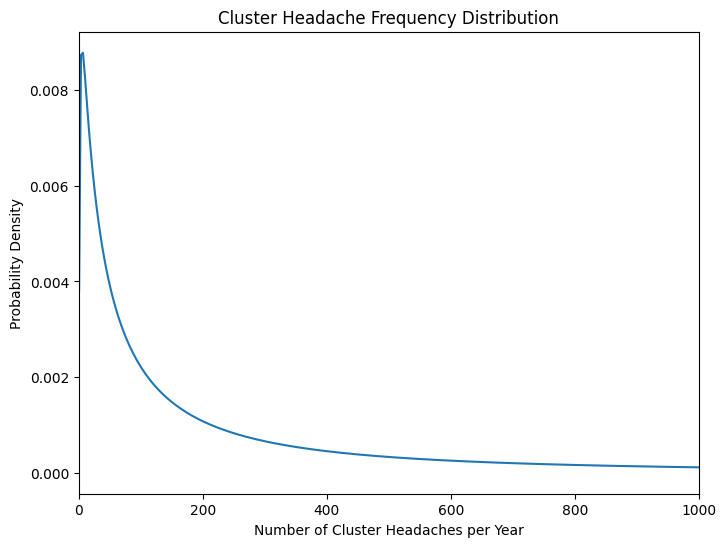

In [153]:
# Percentile data
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98])
cluster_headaches_per_year = np.array([5, 17, 30, 45, 70, 105, 200, 365, 730, 1095, 2190])

# Fit the lognormal distribution to the percentile data
shape, loc, scale = lognorm.fit(cluster_headaches_per_year, percentiles/100, floc=0)

# Generate the lognormal distribution
rv = lognorm(shape, loc=loc, scale=scale)

# Create an array of x-values for plotting
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 10000)

# Calculate the PDF values
y = rv.pdf(x)

# Plot the lognormal distribution
plt.figure(figsize=(8, 6))
plt.plot(x, y)
# plt.bar(x, y, width=x[1]-x[0])
plt.xlim(0, 1000)  # Adjust the x-axis limit as needed
plt.title('Cluster Headache Frequency Distribution')
plt.xlabel('Number of Cluster Headaches per Year')
plt.ylabel('Probability Density')
plt.show()

## Same as above but truncating the distribution to a max number of CHs/year

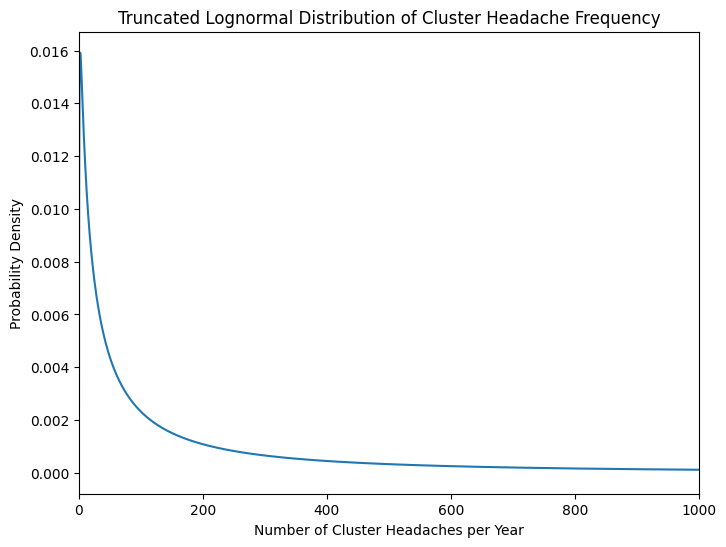

Fitted parameters: s = 1.9463, scale = 96.6879
99.99th percentile: 991.1891


In [184]:
# Percentile data
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98])
cluster_headaches_per_year = np.array([5, 17, 30, 45, 70, 105, 200, 365, 730, 1095, 2190])

# Maximum number of cluster headaches per year
max_headaches = 1000

def truncated_lognorm_cdf(x, s, scale):
    return (lognorm.cdf(x, s, scale=scale) - lognorm.cdf(0, s, scale=scale)) / (lognorm.cdf(max_headaches, s, scale=scale) - lognorm.cdf(0, s, scale=scale))

def truncated_lognorm_ppf(q, s, scale):
    return lognorm.ppf(q * (lognorm.cdf(max_headaches, s, scale=scale) - lognorm.cdf(0, s, scale=scale)) + lognorm.cdf(0, s, scale=scale), s, scale=scale)

def objective(params):
    s, scale = params
    return np.sum((truncated_lognorm_cdf(cluster_headaches_per_year, s, scale) - percentiles/100)**2)

# Fit the truncated lognormal distribution
initial_guess = [1, 100]
result = minimize(objective, initial_guess, method='Nelder-Mead')
s_fit, scale_fit = result.x

# Generate the truncated lognormal distribution
x = np.linspace(0, max_headaches, 10000)
y = lognorm.pdf(x, s_fit, scale=scale_fit) / (lognorm.cdf(max_headaches, s_fit, scale=scale_fit) - lognorm.cdf(0, s_fit, scale=scale_fit))

# Plot the truncated lognormal distribution
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.xlim(0, max_headaches)
plt.title('Truncated Lognormal Distribution of Cluster Headache Frequency')
plt.xlabel('Number of Cluster Headaches per Year')
plt.ylabel('Probability Density')

plt.show()

# Print some statistics
print(f"Fitted parameters: s = {s_fit:.4f}, scale = {scale_fit:.4f}")
print(f"99.99th percentile: {truncated_lognorm_ppf(0.999, s_fit, scale_fit):.4f}")

## Histogram of samples from the distribution above

This tries to reproduce the figure "(Bins of 10, responses between 1 and 1000 CHs per year.)" from [Cluster Headache Frequency Follows a Long-Tail Distribution](https://forum.effectivealtruism.org/posts/XLrzi6TrCqhTMtf8d/cluster-headache-frequency-follows-a-long-tail-distribution).

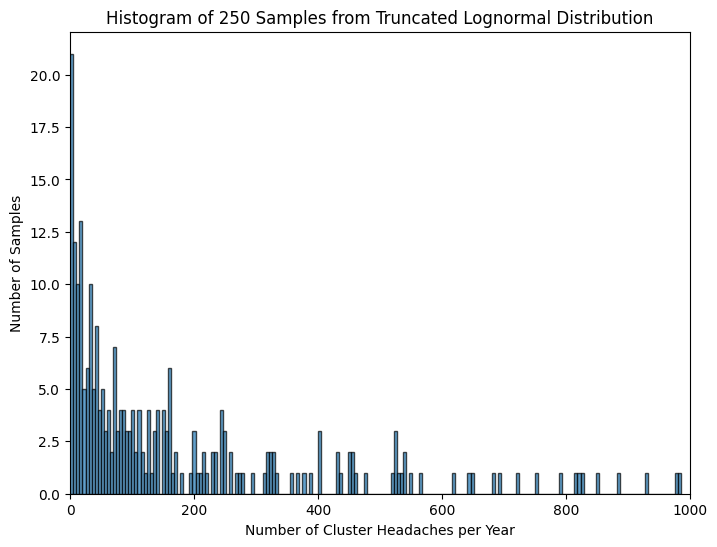

In [185]:
# Function to sample from the truncated lognormal distribution
def sample_truncated_lognormal(n, s, scale, max_value):
    samples = []
    while len(samples) < n:
        x = lognorm.rvs(s, scale=scale)
        if x <= max_value:
            samples.append(x)
    return np.array(samples)

# Generate 250 samples
samples = sample_truncated_lognormal(250, s_fit, scale_fit, max_headaches)

# Plot histogram of samples
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=200, density=False, alpha=0.7, edgecolor='black')

plt.xlim(0, max_headaches)
plt.title('Histogram of 250 Samples from Truncated Lognormal Distribution')
plt.xlabel('Number of Cluster Headaches per Year')
plt.ylabel('Number of Samples')

plt.show()

## Plot the scaled inverse CDF (percent point function)

Attempting to reproduce the second plot from [Cluster Headache Frequency Follows a Long-Tail Distribution](https://forum.effectivealtruism.org/posts/XLrzi6TrCqhTMtf8d/cluster-headache-frequency-follows-a-long-tail-distribution).

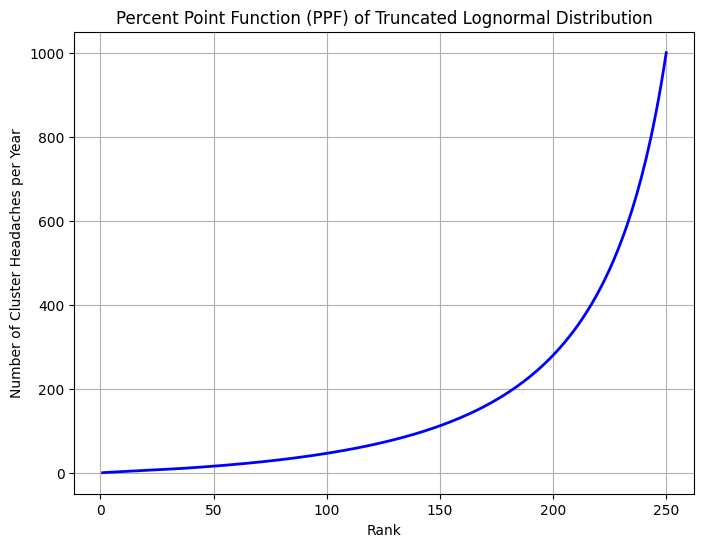

10th percentile: 6.99
Median (50th percentile): 72.97
90th percentile: 485.58
99th percentile: 917.20


In [182]:
# Generate probabilities for PPF
probs = np.linspace(0, 1, 250)
ranks = np.arange(1,251)

# Calculate quantiles using the truncated lognormal PPF
quantiles = [truncated_lognorm_ppf(p, s_fit, scale_fit) for p in probs]

# Plot the PPF
plt.figure(figsize=(8, 6))
plt.plot(ranks, quantiles, 'b-', lw=2)
plt.title('Percent Point Function (PPF) of Truncated Lognormal Distribution')
plt.xlabel('Rank')
plt.ylabel('Number of Cluster Headaches per Year')
plt.grid(True)

plt.show()

# Print some key quantiles
print(f"10th percentile: {truncated_lognorm_ppf(0.1, s_fit, scale_fit):.2f}")
print(f"Median (50th percentile): {truncated_lognorm_ppf(0.5, s_fit, scale_fit):.2f}")
print(f"90th percentile: {truncated_lognorm_ppf(0.9, s_fit, scale_fit):.2f}")
print(f"99th percentile: {truncated_lognorm_ppf(0.99, s_fit, scale_fit):.2f}")

## Average frequency of cluster headaches per year

For the non-truncated distribution, the mean is given by exp(μ + σ^2/2). Note that the QRI survey asked specifically about the total number of CH per year, i.e. not just during the cluster attack periods.

The order of magnitude agrees with Rozen et al. (2001), who estimate 3.2 CH/day for women and 3.0 CH/day for men, though these numbers might be for CH/day during a CH period of 10–11 weeks. In their sample, they additionally say that the average remission period (CH-free period between clusters) is 21 months for women and 23 months for men. This seems surprisingly high to me. I would have expected a few months, maybe up to a year, but not two years. Rounding to 3.1 CH/day, 10.5 weeks, and 22 months (88 weeks) respectively, this frequency would translate to 0.33 CH/day, which is already 5x lower than what I had. Hmm. Maybe they’re just looking at episodic CH sufferers and not chronic ones?

See also Cho et al. 2019: Attack frequency per day: 2.3 for chronic CH sufferers with remission period < 1 month, 1.5 for chronic CH sufferers with remission period of 1–3 months, and 1.1 for episodic CH sufferers (remission period unclear). While they don’t explicitly state it, these numbers probably relate to daily frequency *during a cluster period*, i.e. ignoring remission periods. They also mention that the mean length of a cluster period is 4 weeks for both chronic and episodic sufferers. With this data in mind, here’s an estimate of total annual CH/year according to Claude (numbers slightly off but right order of magnitude):

--

Chronic CH sufferers with remission period < 1 month:
- 2.3 attacks per day (**median**)
- Assuming a 1-week remission period between 4-week cluster periods
- 52 weeks / 5 weeks = 10.4 cluster periods per year
- 2.3 * 28 * 10.4 ≈ 670 attacks per year

Chronic CH sufferers with remission period of 1–3 months:
- 1.5 attacks per day (**median**)
- Assuming an average 2-month remission period
- 12 months / (1 month active + 2 months remission) = 4 cluster periods per year
- 1.5 * 28 * 4 ≈ 168 attacks per year

Episodic CH sufferers:
- 1.1 attacks per day (**median**)
- Typically 1-2 cluster periods per year
- Assuming an average of 1.5 periods per year
- 1.1 * 28 * 1.5 ≈ 46 attacks per year

Now, instead of calculating a weighted average, we should consider the distribution of these types among CH sufferers to estimate an overall average. The exact distribution isn't provided, but based on general knowledge:
Episodic CH is more common, accounting for about 80-90% of cases
Chronic CH is less common, accounting for about 10-20% of cases

Let's assume a distribution of:
- 85% Episodic CH
- 10% Chronic CH with 1-3 months remission
- 5% Chronic CH with < 1 month remission

Given this distribution, we can calculate:
(0.85 * 46) + (0.10 * 168) + (0.05 * 670) ≈ 81 attacks per year (**median**)

--

However, we’re calculating the *median* number of attacks per year. According to QRI’s data, the 50% percentile experiences 70 CH/year, which aligns perfectly with the Cho data. I asked Claude to compare QRI’s numbers with the Cho paper:

--

This new data provides a much more detailed distribution of CH attacks per year compared to the Cho paper. Let's compare and analyze:

1. Comparison with Cho paper:

The Cho paper provided median values and interquartile ranges, which roughly correspond to the 50th, 25th, and 75th percentiles. In the new data:

50th percentile (median): 70 CH/year
In Cho, we calculated about 78 CH/year based on medians

These are quite similar, suggesting consistency between the studies.

The new data shows a wide range from 5 to 2190 CH/year, illustrating the high variability in CH frequency. This explains why we saw such large differences between median and upper quartile calculations in the Cho data.

2. Calculating the mean from the new data:

To estimate the mean, we can use the midpoint of each percentile range and weight it by its probability:

- 5% (0-10%): (5+17)/2 * 0.1 = 1.1
- 10% (10-20%): (17+30)/2 * 0.1 = 2.35
- 10% (20-30%): (30+45)/2 * 0.1 = 3.75
- 10% (30-40%): (45+70)/2 * 0.1 = 5.75
- 10% (40-50%): (70+105)/2 * 0.1 = 8.75
- 10% (50-60%): (105+200)/2 * 0.1 = 15.25
- 10% (60-70%): (200+365)/2 * 0.1 = 28.25
- 10% (70-80%): (365+730)/2 * 0.1 = 54.75
- 10% (80-90%): (730+1095)/2 * 0.1 = 91.25
- 5% (90-95%): (1095+2190)/2 * 0.05 = 81.88
- 3% (95-98%): 2190 * 0.03 = 65.7
- 2% (98-100%): 2190 * 0.02 = 43.8

Sum: 402.58

This calculation suggests a mean of approximately 403 CH attacks per year.

This mean is significantly higher than the median (70 CH/year), which is expected in a right-skewed distribution like this one. It's also higher than our previous estimates based on the Cho paper, likely because this data captures the full range of the distribution, including the very high-frequency sufferers.

In conclusion, this new data provides a more comprehensive view of the CH frequency distribution. It shows that while the median sufferer experiences around 70 attacks per year, the mean is pulled much higher (to about 403) by the significant number of high-frequency sufferers. This detailed distribution would be very valuable for your simulation, as it captures the full range of experiences of CH sufferers.

--

And following up: How do the lower and upper quartiles of the Cho data compare to the new data that I shared?

--

Great question. Let's compare the lower and upper quartiles from the Cho paper with the corresponding percentiles from the new data you shared.

From the Cho paper:

For ECH (which represents 93.6% of cases):
- Lower quartile (25th percentile): 1.0 attacks/day * 21 days/period * 1.5 periods/year ≈ 31.5 attacks/year
- Upper quartile (75th percentile): 3.0 attacks/day * 52.5 days/period * 1.5 periods/year ≈ 236.3 attacks/year

For CCH (6.4% of cases):
- Lower quartile: 1.0 attacks/day * 365 days * 0.75 ≈ 273.75 attacks/year
- Upper quartile: 2.9 attacks/day * 365 days * 0.75 ≈ 793.9 attacks/year

Weighted average for lower quartile:
- (0.936 * 31.5) + (0.064 * 273.75) ≈ 46.9 attacks/year

Weighted average for upper quartile:
- (0.936 * 236.3) + (0.064 * 793.9) ≈ 272.0 attacks/year

From the new data you shared:
- 25th percentile (interpolated between 20th and 30th): ≈ 23.5 attacks/year
- 75th percentile (interpolated between 70th and 80th): ≈ 282.5 attacks/year

Comparison:

Lower quartile (25th percentile):
- Cho data: 46.9 attacks/year
- New data: 23.5 attacks/year

Upper quartile (75th percentile):
- Cho data: 272.0 attacks/year
- New data: 282.5 attacks/year

Observations:
- **The upper quartiles are remarkably similar between the two datasets (272.0 vs 282.5 attacks/year).**
- **The lower quartile in the Cho data is about twice as high as in the new data (46.9 vs 23.5 attacks/year).** This suggests that the Cho study might have had fewer low-frequency sufferers in their sample, or that their method of calculation (which involves some assumptions about attack patterns) might overestimate the frequency for lower-quartile sufferers.
- The new data you shared provides a more detailed and possibly more representative picture of the full range of CH frequencies, especially at the lower end of the spectrum.
- The similarity in the upper quartiles suggests that both studies are capturing similar patterns for high-frequency sufferers, which adds credibility to both datasets.

In [193]:
avg_CH_frequency_annual = rv.mean()
print(f"Average annual CH frequency: {avg_CH_frequency_annual:.0f} ({avg_CH_frequency_annual/365:.2f} per day)")

Average annual CH frequency: 614 (1.68 per day)


## Simulations of total pain-seconds: Simple model

Trying to get a rough order of magnitude of the seconds of pain caused annually by CHs.

The simple model assumes that a single CH attack causes 7/10, 8/10, 9/10, and 10/10 pain with different frequencies (for example, if the average attack lasts 2h, then maybe ~10% is spent in 7/10 pain, ~40% in 8/10 pain, ~40% in 9/10 pain, and 10% in 10/10 pain). We ignore <7/10 pain (in part because onset and offset of attack are fast).

We run Monte Carlo simulations assuming that the percentages vary from CH attach to CH attack.

In [217]:
def get_truncated_normal(mean, sd, low=0, upp=1):
    return truncnorm((low - mean)/sd, (upp - mean)/sd, loc=mean, scale=sd)

# Function to convert seconds to hours and minutes
def seconds_to_time_units(seconds):
    minutes = seconds / 60
    hours = seconds / 3600
    days = seconds / (3600 * 24)
    years = seconds / (3600 * 24 * 365.25)
    return seconds, minutes, hours, days, years

# Function to format output
def format_output(name, mean, ci):
    units = ["Seconds", "Minutes", "Hours", "Days", "Years"]
    mean_values = seconds_to_time_units(mean)
    ci_low_values = seconds_to_time_units(ci[0])
    ci_high_values = seconds_to_time_units(ci[1])
    
    print(f"Expected annual {name}:")
    for unit, mean_val in zip(units, mean_values):
        print(f"  {unit:<7}: {int(round(mean_val)):,}")
    print(f"95% CI for {name}:")
    for unit, low, high in zip(units, ci_low_values, ci_high_values):
        print(f"  {unit:<7}: ({int(round(low)):,}, {int(round(high)):,})")
        
def simulate_suffering(n_simulations, n_sufferers, avg_duration_seconds, avg_frequency, intensity_weights):
    # Define distributions
    # For each level of pain, the range is: mean ± 2*sd with 95% confidence
    pain_7 = get_truncated_normal(0.60, 0.015)
    pain_8 = get_truncated_normal(0.30, 0.15)
    pain_9 = get_truncated_normal(0.08, 0.15)
    pain_10 = get_truncated_normal(0.02, 0.005)

    total_suffering_results = []
    seconds_10_10_results = []
    
    for _ in range(n_simulations):
        # Draw from truncated normal distributions
        p_7 = pain_7.rvs()
        p_8 = pain_8.rvs()
        p_9 = pain_9.rvs()
        p_10 = pain_10.rvs()
        
        # Normalize
        total = p_7 + p_8 + p_9 + p_10
        proportions = [p_7/total, p_8/total, p_9/total, p_10/total]
        
        # Calculate suffering minutes of a single CH attack
        suffering_single_CH = sum([p * w * avg_duration_seconds for p, w in zip(proportions, intensity_weights)])
        
        # Calculate seconds in 10/10 pain
        seconds_10_10_single_CH = proportions[3] * avg_duration_seconds
        
        # Total suffering
        total_suffering = suffering_single_CH * avg_frequency * n_sufferers

        # Total suffering in 10/10 pain only
        total_seconds_10_10 = seconds_10_10_single_CH * avg_frequency * n_sufferers
        
        total_suffering_results.append(total_suffering)
        seconds_10_10_results.append(total_seconds_10_10)
    
    return (np.mean(total_suffering_results), np.percentile(total_suffering_results, [2.5, 97.5]), np.mean(seconds_10_10_results), np.percentile(seconds_10_10_results, [2.5, 97.5]))

# Number of Monte Carlo simulations
n_simulations = 1000

# CH sufferers worldwide
CH_sufferers_worldwide = 8100000

# Average duration of a single CH in seconds
avg_CH_duration_seconds = 60*60

# Average annual frequency of CHs
avg_CH_frequency_annual = rv.mean()


# Weights for 7/10, 8/10, 9/10, and 10/10 pain. 
# Let's for now use linear weights with 10/10 as the basis, simply to be able to calculate the 10/10 seconds directly.
intensity_weights = [.7,.8,.9,1.0]

mean_suffering, ci_suffering, mean_10_10, ci_10_10 = simulate_suffering(n_simulations, CH_sufferers_worldwide, avg_CH_duration_seconds, avg_CH_frequency_annual, intensity_weights)

# Print results
format_output("suffering (weighted)", mean_suffering, ci_suffering)
print()
format_output("time in 10/10 pain", mean_10_10, ci_10_10)

Expected annual suffering (weighted):
  Seconds: 13,619,119,611,477
  Minutes: 226,985,326,858
  Hours  : 3,783,088,781
  Days   : 157,628,699
  Years  : 431,564
95% CI for suffering (weighted):
  Seconds: (13,096,030,711,404, 14,117,603,348,342)
  Minutes: (218,267,178,523, 235,293,389,139)
  Hours  : (3,637,786,309, 3,921,556,486)
  Days   : (151,574,430, 163,398,187)
  Years  : (414,988, 447,360)

Expected annual time in 10/10 pain:
  Seconds: 335,182,580,672
  Minutes: 5,586,376,345
  Hours  : 93,106,272
  Days   : 3,879,428
  Years  : 10,621
95% CI for time in 10/10 pain:
  Seconds: (147,326,972,744, 547,905,982,787)
  Minutes: (2,455,449,546, 9,131,766,380)
  Hours  : (40,924,159, 152,196,106)
  Days   : (1,705,173, 6,341,504)
  Years  : (4,669, 17,362)


In [218]:
# Quick sanity check
seconds = CH_sufferers_worldwide * avg_CH_duration_seconds * avg_CH_frequency_annual
# seconds = avg_CH_duration_seconds * avg_CH_frequency_annual
print(seconds_to_time_units(seconds))

(17911499429354.484, 298524990489.2414, 4975416508.154023, 207309021.17308432, 567581.1667983143)


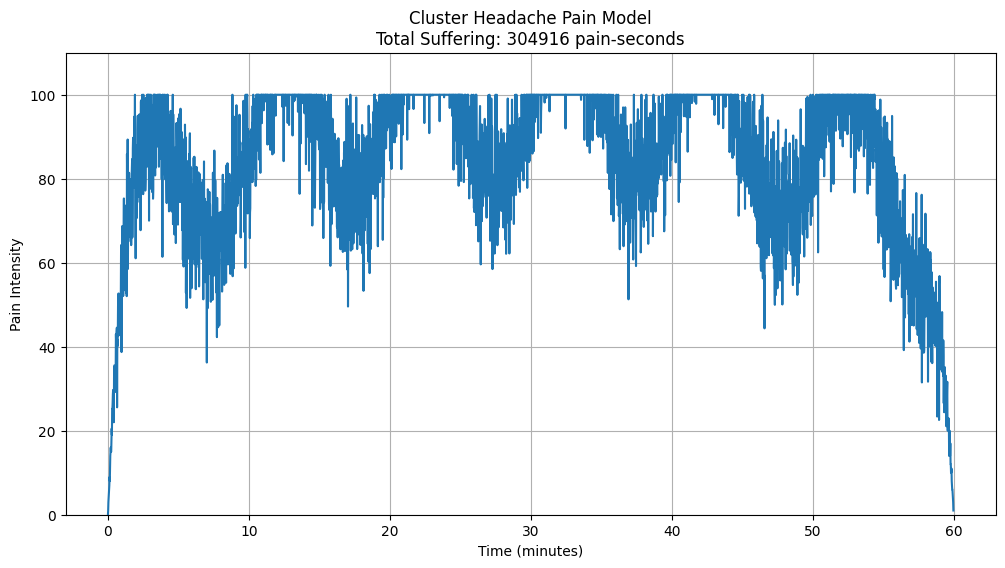

Total suffering: 304916 pain-seconds
Average pain level: 84.7
Maximum pain level: 100.0
Minimum pain level: 0.0


In [219]:
def pain_model(t, total_duration=3600):
    # Quick rise in the first 300 seconds
    rise = 100 * (1 - np.exp(-t / 60))
    
    # Decline in the last 300 seconds
    decline = 100 * (1 - np.exp(-(total_duration - t) / 60)) if t > (total_duration - 300) else 100
    
    # Base function with larger variation
    B = 75 + 25 * np.sin(np.pi * t / 3600)
    
    # Sinusoidal variation with larger amplitude
    S = 20 * np.sin(2 * np.pi * t / 600)
    
    # Random component
    R = np.random.normal(0, 10)
    
    # Combine all components
    pain = rise * decline * (B + S + R) / 10000
    
    return np.clip(pain, 0, 100)

def apply_jnd(pain):
    jnd = max(1, 0.05 * pain)  # JND is 5% of current pain, minimum 1
    return round(pain / jnd) * jnd

# Model a 60-minute (3600-second) attack
total_duration = 3600
times = np.arange(total_duration)
pain_levels = np.array([apply_jnd(pain_model(t, total_duration)) for t in times])

# Calculate total suffering
total_suffering = np.sum(pain_levels)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times / 60, pain_levels)  # Convert seconds to minutes for x-axis
plt.title(f"Cluster Headache Pain Model\nTotal Suffering: {total_suffering:.0f} pain-seconds")
plt.xlabel("Time (minutes)")
plt.ylabel("Pain Intensity")
plt.ylim(0, 110)
plt.grid(True)
plt.show()

print(f"Total suffering: {total_suffering:.0f} pain-seconds")
print(f"Average pain level: {np.mean(pain_levels):.1f}")
print(f"Maximum pain level: {np.max(pain_levels):.1f}")
print(f"Minimum pain level: {np.min(pain_levels):.1f}")

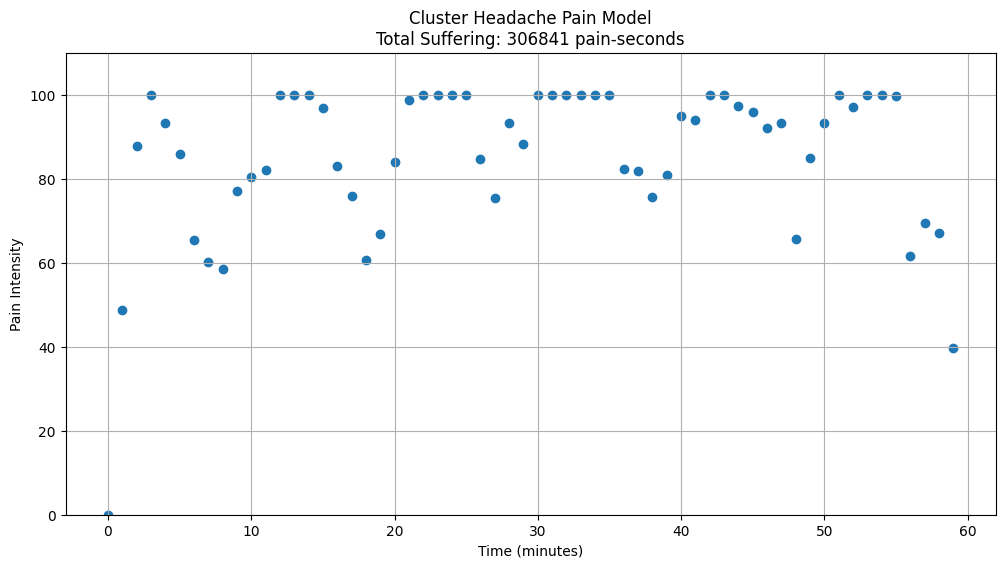

Total suffering: 306841 pain-seconds
Average pain level: 85.2
Maximum pain level: 100.0
Minimum pain level: 0.0


In [220]:
def pain_model(t, total_duration=60):
    # Quick rise in the first 5 minutes
    rise = 100 * (1 - np.exp(-t / 1))
    
    # Decline in the last 5 minutes
    decline = 100 * (1 - np.exp(-(total_duration - t) / 1)) if t > (total_duration - 5) else 100
    
    # Base function with larger variation
    B = 75 + 25 * np.sin(np.pi * t / 60)
    
    # Sinusoidal variation with larger amplitude
    S = 20 * np.sin(2 * np.pi * t / 10)
    
    # Random component
    R = np.random.normal(0, 10)
    
    # Combine all components
    pain = rise * decline * (B + S + R) / 10000
    
    return np.clip(pain, 0, 100)

def apply_jnd(pain):
    jnd = max(1, 0.05 * pain)  # JND is 5% of current pain, minimum 1
    return round(pain / jnd) * jnd

# Model a 60-minute attack
total_duration = 60
times = np.arange(total_duration)
pain_levels = np.array([apply_jnd(pain_model(t, total_duration)) for t in times])

# Calculate total suffering in pain-minutes
total_suffering_minutes = np.sum(pain_levels)

# Convert to pain-seconds
total_suffering_seconds = total_suffering_minutes * 60

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(times, pain_levels)
plt.title(f"Cluster Headache Pain Model\nTotal Suffering: {total_suffering_seconds:.0f} pain-seconds")
plt.xlabel("Time (minutes)")
plt.ylabel("Pain Intensity")
plt.ylim(0, 110)
plt.grid(True)
plt.show()

print(f"Total suffering: {total_suffering_seconds:.0f} pain-seconds")
print(f"Average pain level: {np.mean(pain_levels):.1f}")
print(f"Maximum pain level: {np.max(pain_levels):.1f}")
print(f"Minimum pain level: {np.min(pain_levels):.1f}")

## Exponential (or polynomial) fit

In [ ]:
# Define the known points
x = np.array([0, 7.42, 10])
y = np.array([0, 50, 100])

# Define the general exponential function
def exp_func(x, A, B, C):
    return A * np.exp(B * x) + C

# Fit the function to the data
popt, pcov = curve_fit(exp_func, x, y, p0=[1, 0.3, 0])

# Fit a 2nd degree polynomial
coeffs = np.polyfit(x, y, 2)

# Create a function from the fitted parameters
def pain_function(t):
    return exp_func(t, *popt)
    # return np.polyval(coeffs, t)

# Generate points for plotting
t = np.linspace(0, 10, 100)
pain_levels = pain_function(t)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, pain_levels)
plt.title("Exponential Pain Function")
plt.xlabel("Linear Pain Intensity")
plt.ylabel("Exponential Pain Intensity")
plt.ylim(-5, 105)
plt.grid(True)

# Add points used for fitting
plt.scatter(x, y, color='red', s=50, zorder=5)

plt.show()

# Print the fitted parameters
print("Fitted parameters (A, B, C):")
print(popt)

# Verify the function passes through the given points
print("\nVerification:")
print(f"f(0) = {pain_function(0):.2f}")
print(f"f(7.42) = {pain_function(7.42):.2f}")
print(f"f(10) = {pain_function(10):.2f}")

# Print the mapping
print("\nMapping of linear scale to new scale:")
for x in range(11):
    print(f"f({x}) = {pain_function(x):.2f}")

In [ ]:
# Define the known points
x = np.array([0, 7.42, 10])
y = np.array([0, 50, 100])

# Define the general exponential function
def exp_func(x, A, B, C):
    return A * np.exp(B * x) + C

# Fit the function to the data
popt, pcov = curve_fit(exp_func, x, y, p0=[1, 0.3, 0])

# Fit a 2nd degree polynomial
coeffs = np.polyfit(x, y, 2)

# Create a function from the fitted parameters
def pain_function(t):
    return exp_func(t, *popt)
    # return np.polyval(coeffs, t)

# Generate points for plotting
t = np.linspace(0, 10, 100)
pain_levels = pain_function(t)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, pain_levels)
plt.title("Exponential Pain Function")
plt.xlabel("Linear Pain Intensity")
plt.ylabel("Exponential Pain Intensity")
plt.ylim(-5, 105)
plt.grid(True)

# Add points used for fitting
plt.scatter(x, y, color='red', s=50, zorder=5)

plt.show()

# Print the fitted parameters
print("Fitted parameters (A, B, C):")
print(popt)

# Verify the function passes through the given points
print("\nVerification:")
print(f"f(0) = {pain_function(0):.2f}")
print(f"f(7.42) = {pain_function(7.42):.2f}")
print(f"f(10) = {pain_function(10):.2f}")

# Print the mapping
print("\nMapping of linear scale to new scale:")
for x in range(11):
    print(f"f({x}) = {pain_function(x):.2f}")

/var/folders/1c/z3t23xb17hlb3_r7h9cx0cvc0000gn/T/ipykernel_56872/1115791725.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_func, x, y, p0=[1, 0.3, 0])


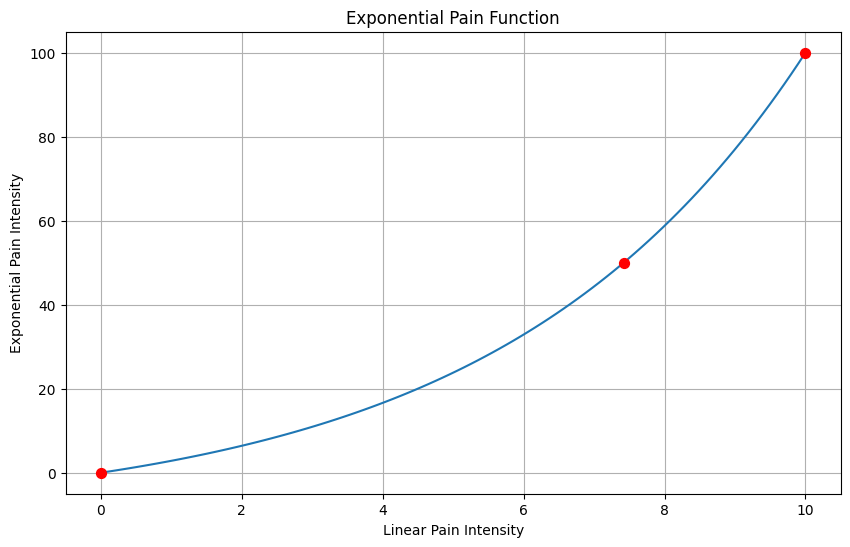

Fitted parameters (A, B, C):
[ 10.83784407   0.23250242 -10.83784407]

Verification:
f(0) = 0.00
f(7.42) = 50.00
f(10) = 100.00

Mapping of linear scale to new scale:
f(0) = 0.00
f(1) = 2.84
f(2) = 6.42
f(3) = 10.93
f(4) = 16.63
f(5) = 23.82
f(6) = 32.89
f(7) = 44.34
f(8) = 58.78
f(9) = 77.01
f(10) = 100.00


In [120]:
# Define the known points
x = np.array([0, 7.42, 10])
y = np.array([0, 50, 100])

# Define the general exponential function
def exp_func(x, A, B, C):
    return A * np.exp(B * x) + C

# Fit the function to the data
popt, pcov = curve_fit(exp_func, x, y, p0=[1, 0.3, 0])

# Fit a 2nd degree polynomial
coeffs = np.polyfit(x, y, 2)

# Create a function from the fitted parameters
def pain_function(t):
    return exp_func(t, *popt)
    # return np.polyval(coeffs, t)

# Generate points for plotting
t = np.linspace(0, 10, 100)
pain_levels = pain_function(t)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, pain_levels)
plt.title("Exponential Pain Function")
plt.xlabel("Linear Pain Intensity")
plt.ylabel("Exponential Pain Intensity")
plt.ylim(-5, 105)
plt.grid(True)

# Add points used for fitting
plt.scatter(x, y, color='red', s=50, zorder=5)

plt.show()

# Print the fitted parameters
print("Fitted parameters (A, B, C):")
print(popt)

# Verify the function passes through the given points
print("\nVerification:")
print(f"f(0) = {pain_function(0):.2f}")
print(f"f(7.42) = {pain_function(7.42):.2f}")
print(f"f(10) = {pain_function(10):.2f}")

# Print the mapping
print("\nMapping of linear scale to new scale:")
for x in range(11):
    print(f"f({x}) = {pain_function(x):.2f}")

## Linear scale with exponential "kink" starting at 5

I initially tried to start the "kink" at 6 but the exponential function then cannot pass through (7.42, 50) and (10, 100).

Mapping of linear scale to new scale:
f(0.0) = 0.00
f(1.0) = 1.00
f(2.0) = 2.00
f(3.0) = 3.00
f(4.0) = 4.00
f(5.0) = 5.00
f(6.0) = 23.38
f(7.0) = 42.06
f(8.0) = 61.06
f(9.0) = 80.37
f(10.0) = 100.00
Pain level at x=7.42: 50.00


/var/folders/1c/z3t23xb17hlb3_r7h9cx0cvc0000gn/T/ipykernel_56872/1477774997.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_func, x_exp, y_exp, p0=[1, 0.5, 0], maxfev=10000)


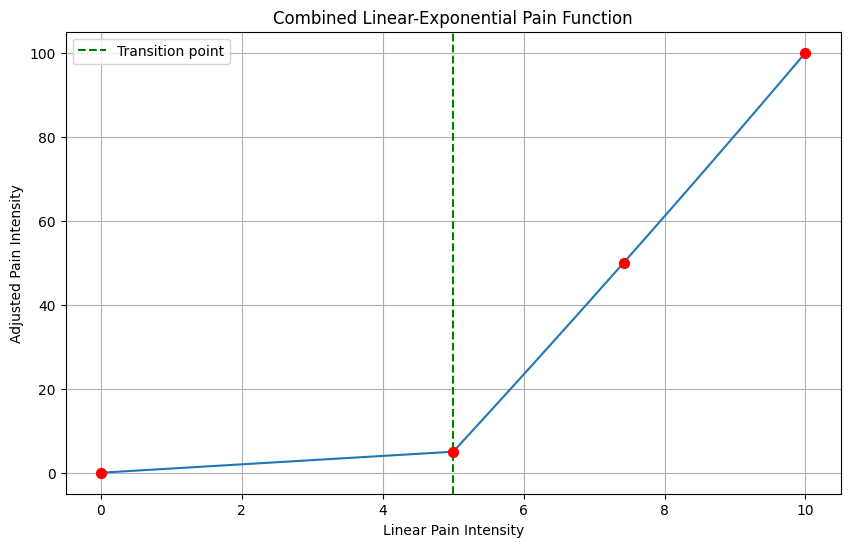


Fitted parameters: A = 1014.9900, B = 0.0165, C = -1097.4531


In [123]:
def exp_func(x, A, B, C):
    return A * np.exp(B * x) + C

# Define the known points for the exponential part
x_exp = np.array([5, 7.42, 10])
y_exp = np.array([5, 50, 100])

# Fit the exponential function
popt, _ = curve_fit(exp_func, x_exp, y_exp, p0=[1, 0.5, 0], maxfev=10000)

def pain_function(x):
    if isinstance(x, (int, float)):
        return x if x <= 5 else exp_func(x, *popt)
    else:
        return np.where(x <= 5, x, exp_func(x, *popt))

# Print the mapping
print("Mapping of linear scale to new scale:")
for x in np.arange(0, 10.1, 1):  # Using 0.5 steps for more detail
    print(f"f({x:.1f}) = {pain_function(x):.2f}")

# Calculate and print some statistics
t = np.linspace(0, 10, 100)
pain_levels = pain_function(t)

print(f"Pain level at x=7.42: {pain_function(7.42):.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, pain_levels)
plt.title("Combined Linear-Exponential Pain Function")
plt.xlabel("Linear Pain Intensity")
plt.ylabel("Adjusted Pain Intensity")
plt.ylim(-5, 105)
plt.grid(True)

# Add points used for fitting
plt.scatter([0, 5, 7.42, 10], [0, 5, 50, 100], color='red', s=50, zorder=5)

# Add a line to show where the function transitions from linear to exponential
plt.axvline(x=5, color='green', linestyle='--', label='Transition point')

plt.legend()
plt.show()

# Print the fitted parameters
print(f"\nFitted parameters: A = {popt[0]:.4f}, B = {popt[1]:.4f}, C = {popt[2]:.4f}")